#Deep Learning Model

In [0]:
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow import feature_column
from tensorflow.keras import layers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_root = "/content/drive/My Drive/Final Project/"

In [0]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Read data and transform to Dataframe

In [0]:
traincsv = pd.read_csv(drive_root+"Clean Data/train_set_new.csv", low_memory=False)
train = traincsv[['review_id','user_id', 'business_id', 'rating']].copy()

last_review = pd.read_csv(drive_root+"Clean Data/last_review.csv", low_memory=False)
test = last_review[['review_id','user_id', 'business_id', 'rating']].copy()

#val_set = pd.read_csv(drive_root+"Clean Data/test_set_new.csv", low_memory=False)
#create a validation set with a special split that ensures that every user in on train and validation set
val = (train.groupby('user_id')).apply(lambda x: x.sample(n=round(0.2*len(x)))).droplevel(level=0)
#val = val_set[['review_id','user_id', 'business_id', 'rating']].copy()

In [0]:
val = val.sample(frac=1).reset_index(drop=True)

Add extra data of business/user -> features

In [0]:
categoriescsv =  pd.read_csv(drive_root+"Clean Data/categorization.csv", low_memory=False)

In [0]:
categoriescsv.head()

,review_id,user_id,business_id,stars,city,state,is_open,business_popularity_bin,user_activity_bin
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.00,Las Vegas,NV,1.00,high,medium
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.00,Las Vegas,NV,1.00,high,exclude
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.00,Chandler,AZ,1.00,high,low
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.00,Calgary,AB,1.00,medium,exclude
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.00,Scottsdale,AZ,1.00,high,exclude


Add categories of business data

In [0]:
buscsv = pd.read_csv(drive_root+"Clean Data/business_df.csv", low_memory=False, usecols=['business_id','categories'])
buscsv.head()

,business_id,categories
0,1SWheh84yJXfytovILXOAQ,"Golf, Active Life"
1,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese"
3,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services"
4,HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi..."


In [0]:
#merge features with categories
cat_bus = pd.merge(categoriescsv,buscsv, on=['business_id'], how='inner')

In [0]:
#merge train/test/val with features
train2 = pd.merge(train, cat_bus, on=['review_id','user_id','business_id'],how='inner')
test2 = pd.merge(test, cat_bus, on=['review_id','user_id','business_id'],how='inner')
val2 = pd.merge(val, cat_bus, on=['review_id','user_id','business_id'],how='inner')

In [0]:
train2.head(3)

,review_id,user_id,business_id,rating,stars,city,state,is_open,business_popularity_bin,user_activity_bin,categories
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.00,1.00,Las Vegas,NV,1.00,high,medium,"Fitness & Instruction, Doctors, Health & Medic..."
1,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.00,5.00,Chandler,AZ,1.00,high,low,"Health & Medical, Cosmetic Dentists, Orthodont..."
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.00,3.00,Markham,ON,1.00,high,high,"Food, Chinese, Restaurants, Desserts"


In [0]:
#check for missing categories in training
train2.isna().sum()

review_id                    0
user_id                      0
business_id                  0
rating                       0
stars                        0
city                         2
state                        0
is_open                      0
business_popularity_bin      0
user_activity_bin            0
categories                 952
dtype: int64

In [0]:
#select columns and define types of variables
dl_train = train2[["rating","city","state","is_open","business_popularity_bin","user_activity_bin","categories"]].copy()
dl_test = test2[["rating","city","state","is_open","business_popularity_bin","user_activity_bin","categories"]].copy()
dl_val = val2[["rating","city","state","is_open","business_popularity_bin","user_activity_bin","categories"]].copy()

dl_train = dl_train.astype({"rating": float, "city":str, "state": str, "is_open":int, "business_popularity_bin":str, "user_activity_bin": str, "categories":str})
dl_test = dl_test.astype({"rating": float, "city":str, "state": str, "is_open":int, "business_popularity_bin":str, "user_activity_bin": str, "categories":str})
dl_val = dl_val.astype({"rating": float, "city":str, "state": str, "is_open":int, "business_popularity_bin":str, "user_activity_bin": str,"categories":str})

In [0]:
#Add a column of standardized ratings
#std_train = dl_train[['rating', 'city', 'state', 'is_open', 'business_popularity_bin', 'user_activity_bin','categories']].copy()
#std_test = dl_test[['rating', 'city', 'state', 'is_open', 'business_popularity_bin', 'user_activity_bin','categories']].copy()
#std_val = dl_val[['rating', 'city', 'state', 'is_open', 'business_popularity_bin', 'user_activity_bin','categories']].copy()

#std_train['rating'] = pd.to_numeric(std_train.rating)
#std_test['rating'] = pd.to_numeric(std_test.rating)
#std_val['rating'] = pd.to_numeric(std_val.rating)

def norm(x):
  '''
  x: array
  '''
  return (x - dl_train.rating.mean()) / dl_train.rating.std()


dl_train['rating_std'] = norm(dl_train['rating'])
dl_test['rating_std'] = norm(dl_test['rating'])
dl_val['rating_std'] = norm(dl_train['rating'])

### Create a tensorflow Dataset from pandas Dataframe

Define variable types

In [0]:
cities = dl_train.city.unique()
states = dl_train.state.unique()
isopen = dl_train.is_open.unique()
business_pop = dl_train.business_popularity_bin.unique()
user_actv =  dl_train.user_activity_bin.unique()

In [0]:
print("Number of cities: ",len(cities))
print("Number of states: ",len(states))
print("Business is open categories:", isopen)
print("Business popularity categories: ",business_pop)
print("User activity categories: ",user_actv)


Number of cities:  1142
Number of states:  29
Business is open categories: [1 0]
Business popularity categories:  ['high' 'medium' 'low']
User activity categories:  ['medium' 'low' 'high']


Create tensorflow categorical columns from features

In [0]:
cities_ft = feature_column.categorical_column_with_vocabulary_list('city', cities.tolist())
states_ft = feature_column.categorical_column_with_vocabulary_list('state', states.tolist())
isopen_ft = feature_column.categorical_column_with_vocabulary_list('is_open', isopen.tolist())
business_pop_ft = feature_column.categorical_column_with_vocabulary_list('business_popularity_bin', business_pop.tolist())
user_actv_ft = feature_column.categorical_column_with_vocabulary_list('user_activity_bin', user_actv.tolist())

In [0]:
cities_embedding = feature_column.embedding_column(cities_ft, dimension=8) #dimension is an hyperparameter to tune
state_embedding = feature_column.indicator_column(states_ft)
isopen_embedding = feature_column.indicator_column(isopen_ft)
businesspop_embedding = feature_column.indicator_column(business_pop_ft)
useractv_embedding = feature_column.indicator_column(user_actv_ft)

Process business categories to tokens 

In [0]:
#Choose a vocabulary size
VOCAB_SIZE = 1000

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(dl_train.categories)

print("Word index", len(tokenizer.word_index))

Word index 1386


In [0]:
#Sanity check the tokens from categories
print(tokenizer.word_index.keys())

dict_keys(['restaurants', 'food', 'bars', 'american', 'services', 'nightlife', 'new', 'traditional', 'breakfast', 'event', 'brunch', 'shopping', 'planning', 'sandwiches', 'arts', 'spas', 'tea', 'mexican', 'hotels', 'entertainment', 'pizza', 'burgers', 'italian', 'beauty', 'coffee', 'home', 'seafood', 'wine', 'japanese', 'desserts', 'chinese', 'local', 'hair', 'beer', 'sushi', 'medical', 'salad', 'travel', 'specialty', 'asian', 'fast', 'health', 'stores', 'fusion', 'repair', 'salons', 'cafes', 'steakhouses', 'automotive', 'auto', 'venues', 'life', 'active', 'bakeries', 'sports', 'spirits', 'cocktail', 'pubs', 'barbeque', 'pet', 'caterers', 'ice', 'chicken', 'vegetarian', 'lounges', 'mediterranean', 'thai', 'cream', 'frozen', 'yogurt', 'shops', 'spaces', 'fashion', 'grocery', 'wings', 'car', 'buffets', 'nail', 'diners', 'tapas', 'juice', 'smoothies', 'casinos', 'music', 'vegan', 'removal', 'free', 'gluten', 'delis', 'care', 'canadian', 'french', 'day', 'flavor', 'vietnamese', 'korean', '

In [0]:
#Add created tokens to tf categorical columns
categories_ft = feature_column.categorical_column_with_vocabulary_list('categories', tokenizer.word_index.keys())
categories_embedding = feature_column.embedding_column(categories_ft, dimension=8)

Create a tf Feature Column with all embeddings created above


1.   One feature column list for user/business features
2.   Another feature column list for user/business features + categories

We are creating 2 feature column lists to test a model only for features and another model for features+categories


In [0]:
feature_columns_1 = []

# embedding cols
feature_columns_1.append(cities_embedding)
feature_columns_1.append(state_embedding)
feature_columns_1.append(isopen_embedding)
feature_columns_1.append(businesspop_embedding)
feature_columns_1.append(useractv_embedding)

feature_columns_2 = []
feature_columns_2.append(cities_embedding)
feature_columns_2.append(state_embedding)
feature_columns_2.append(isopen_embedding)
feature_columns_2.append(businesspop_embedding)
feature_columns_2.append(useractv_embedding)
feature_columns_2.append(categories_embedding)

In [0]:
#Convert the list of feature columns to Feature layer input for model
feature_layer_1 = tf.keras.layers.DenseFeatures(feature_columns_1)
feature_layer_2 = tf.keras.layers.DenseFeatures(feature_columns_2)

### Decide on type of model to run

Given the nature of our project - predict a rating between 1 and 5- we can treat this problem in 2 ways:


1.   **Multi-classification problem**: we want a model to estimate probabilities of belonging to 5 classes (i.e. treat each rating as if it were a class).
2.   **Continous prediction**: a model that given an observation and a standardized rating, it can predict a standardize value as a rating. 



In [0]:
#funtion to create tf dataset with ratings as classes (hot encoding them) 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def df_to_dataset_1(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  dataframe.pop('rating_std')
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(dataframe['rating'])
  encoded_Y = encoder.transform(dataframe['rating'])
  labels = np_utils.to_categorical(encoded_Y)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

Using TensorFlow backend.


In [0]:
#function to create tf dataset with ratings as a continuous value
def df_to_dataset_2(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  dataframe.pop('rating')
  labels = dataframe.pop('rating_std')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

Create TF datasets for the 2 types of approaches

In [0]:
batch_size = 1000

In [0]:
#Dataset for model 1 - just features
train_m1f1 = df_to_dataset_1(dl_train.loc[:, dl_train.columns != 'categories'], batch_size=batch_size)
val_m1f1 = df_to_dataset_1(dl_val.loc[:, dl_val.columns != 'categories'], shuffle=False, batch_size=batch_size)
test_m1f1 = df_to_dataset_1(dl_test.loc[:, dl_test.columns != 'categories'], shuffle=False, batch_size=batch_size)

In [0]:
#Dataset for model 1 - features + categories
train_m1f2 = df_to_dataset_1(dl_train, batch_size=batch_size)
val_m1f2 = df_to_dataset_1(dl_val, shuffle=False, batch_size=batch_size)
test_m1f2 = df_to_dataset_1(dl_test, shuffle=False, batch_size=batch_size)

In [0]:
#Dataset for model 2 - just features
train_m2f1 = df_to_dataset_2(dl_train.loc[:, dl_train.columns != 'categories'], batch_size=batch_size)
val_m2f1 = df_to_dataset_2(dl_val.loc[:, dl_val.columns != 'categories'], shuffle=False, batch_size=batch_size)
test_m2f1 = df_to_dataset_2(dl_test.loc[:, dl_test.columns != 'categories'], shuffle=False, batch_size=batch_size)

In [0]:
#Dataset for model 2 - features + categories
train_m2f2 = df_to_dataset_2(dl_train, batch_size=batch_size)
val_m2f2 = df_to_dataset_2(dl_val, shuffle=False, batch_size=batch_size)
test_m2f2 = df_to_dataset_2(dl_test, shuffle=False, batch_size=batch_size)

In [0]:
for feature_batch, label_batch in train_m2f1.take(1):
  print('Every feature:', list(feature_batch.keys()))
  #print('A batch of states:', feature_batch['state'])
  #print('A batch of targets:', label_batch )

### Models

We'll use MSE as the loss function to minimize

#### Model 1: Classsification using features

In [0]:
model1_f1 = tf.keras.Sequential([
  feature_layer_1,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='tanh'),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model1_f1.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history1_f1 = model1_f1.fit(train_m1f1,
          validation_data=val_m1f1,
          epochs=5)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train for 4253 steps, validate for 855 steps
Epoch 1/5
4253/4253 [==============================] - 65s 15ms/step - loss: 0.1425 - accuracy: 0.4172 - root_mean_squared_error: 0.3775 - val_loss: 0.1426 - val_accuracy: 0.4186 - val_root_mean_squared_error: 0.3776
Epoch 2/5
4253/4253 [==============================] - 62s 15ms/step - loss: 0.1424 - accuracy: 0.4178 - root_mean_squared_error: 0.3773 - val_loss: 0.1422 - val_accuracy: 0.4184 - val_root_mean_squared_error: 0.3771
Epoch 3/5
4253/4253 [==============================] - 63s 15ms/step - loss: 0.1423 - accuracy: 0.4180 - root_mean_squared_error: 0.3773 - val_loss: 0.1422 - val_accuracy: 0.4184 - val_root_mean_squared_error: 0.3772
Epoch 4/5
4253/4253 [==============================] - 6

#### Model 2: Classification using features + categories

In [0]:
model1_f2 = tf.keras.Sequential([
  feature_layer_2,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='tanh'),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model1_f2.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history1_f2 = model1_f2.fit(train_m1f2,
          validation_data=val_m1f2,
          epochs=5)

Train for 4253 steps, validate for 855 steps
Epoch 1/5
4253/4253 [==============================] - 74s 17ms/step - loss: 0.1425 - accuracy: 0.4173 - root_mean_squared_error: 0.3775 - val_loss: 0.1424 - val_accuracy: 0.4182 - val_root_mean_squared_error: 0.3774
Epoch 2/5
4253/4253 [==============================] - 73s 17ms/step - loss: 0.1423 - accuracy: 0.4179 - root_mean_squared_error: 0.3773 - val_loss: 0.1423 - val_accuracy: 0.4179 - val_root_mean_squared_error: 0.3772
Epoch 3/5
4253/4253 [==============================] - 73s 17ms/step - loss: 0.1423 - accuracy: 0.4181 - root_mean_squared_error: 0.3772 - val_loss: 0.1422 - val_accuracy: 0.4187 - val_root_mean_squared_error: 0.3771
Epoch 4/5
4253/4253 [==============================] - 73s 17ms/step - loss: 0.1423 - accuracy: 0.4182 - root_mean_squared_error: 0.3772 - val_loss: 0.1422 - val_accuracy: 0.4188 - val_root_mean_squared_error: 0.3771
Epoch 5/5
4253/4253 [==============================] - 72s 17ms/step - loss: 0.1423 - a

#### Model 3: Continuous using features

In [0]:
model2_f1 = tf.keras.Sequential([
  feature_layer_1,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='tanh'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model2_f1.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history2_f1 = model2_f1.fit(train_m2f1,
          validation_data=val_m2f1,
          epochs=5)

Train for 4253 steps, validate for 855 steps
Epoch 1/5
4253/4253 [==============================] - 59s 14ms/step - loss: 0.9898 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9949 - val_loss: 1.0181 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0088
Epoch 2/5
4253/4253 [==============================] - 58s 14ms/step - loss: 0.9889 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9944 - val_loss: 1.0106 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0051
Epoch 3/5
4253/4253 [==============================] - 58s 14ms/step - loss: 0.9887 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9943 - val_loss: 1.0109 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0053
Epoch 4/5
4253/4253 [==============================] - 59s 14ms/step - loss: 0.9885 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9943 - val_loss: 1.0103 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0049
Epoch 5/5
4253/4253 [==============================] - 

#### Model 4: Continuous using features + categories

In [0]:
model2_f2 = tf.keras.Sequential([
  feature_layer_2,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='tanh'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model2_f2.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mean_squared_error',
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history2_f2 = model2_f2.fit(train_m2f2,
          validation_data=val_m2f2,
          epochs=5)

Train for 4253 steps, validate for 855 steps
Epoch 1/5
4253/4253 [==============================] - 70s 16ms/step - loss: 0.9897 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9948 - val_loss: 1.0129 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0062
Epoch 2/5
4253/4253 [==============================] - 69s 16ms/step - loss: 0.9887 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9943 - val_loss: 1.0145 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0071
Epoch 3/5
4253/4253 [==============================] - 69s 16ms/step - loss: 0.9884 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9942 - val_loss: 1.0136 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0066
Epoch 4/5
4253/4253 [==============================] - 68s 16ms/step - loss: 0.9883 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.9941 - val_loss: 1.0108 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0052
Epoch 5/5
4253/4253 [==============================] - 

### Results

Plots of loss for each model

In [0]:
import matplotlib.pyplot as plt
def plot(hist, model):
    tr_loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # Get the number of epochs
    epochs = range(len(tr_loss))

    _ = plt.figure()
    plt.title('Model %s loss'%model)
    plt.plot(epochs, tr_loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

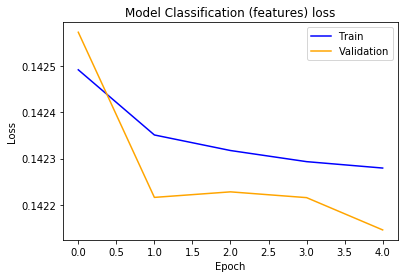

In [0]:
plot(history1_f1, "Classification (features)")

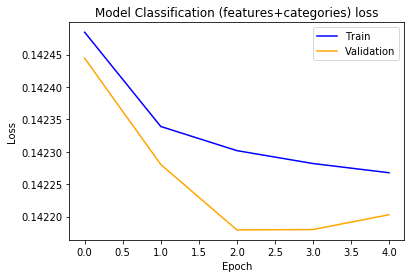

In [0]:
plot(history1_f2, "Classification (features+categories)")

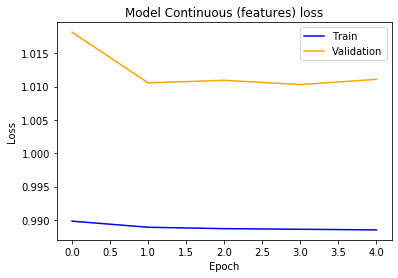

In [0]:
plot(history2_f1, "Continuous (features)")

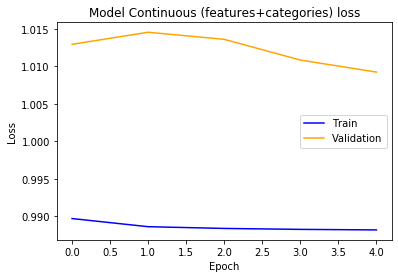

In [0]:
plot(history2_f2, "Continuous (features+categories)")

Evaluation of each model in test set (last rating of each user)

In [0]:
rmse1_f1 = model1_f1.evaluate(test_m1f1)
print("\nRMSE of Classification (features) model: {} \n".format(rmse1_f1[2]))

rmse1_f2 = model1_f2.evaluate(test_m1f2)
print("\nRMSE of Classification (features+categories) model: {} \n".format(rmse1_f2[2]))

rmse2_f1 = model2_f1.evaluate(test_m2f1)
print("\nRMSE of Continuous (features) model: {} \n".format(rmse2_f1[2]))

rmse2_f2 = model2_f2.evaluate(test_m2f2)
print("\nRMSE of Continuous (features+categories) model: {} \n".format(rmse2_f2[2]))

287/287 [==============================] - 2s 7ms/step - loss: 0.1338 - accuracy: 0.5013 - root_mean_squared_error: 0.3657

RMSE of Classification (features) model: 0.3657178282737732 

287/287 [==============================] - 2s 8ms/step - loss: 0.1347 - accuracy: 0.5011 - root_mean_squared_error: 0.3669

RMSE of Classification (features+categories) model: 0.3669266700744629 

287/287 [==============================] - 2s 6ms/step - loss: 1.2566 - accuracy: 0.0000e+00 - root_mean_squared_error: 1.1209

RMSE of Continuous (features) model: 1.1208834648132324 

287/287 [==============================] - 2s 7ms/step - loss: 1.2558 - accuracy: 0.0000e+00 - root_mean_squared_error: 1.1205

RMSE of Continuous (features+categories) model: 1.1205391883850098 



Predicitions on test set (last rating of each user)

In [0]:
last_rating_m1f1 = model1_f1.predict(test_m1f1)
last_rating_m1f2 = model1_f2.predict(test_m1f2)
last_rating_m2f1 = model2_f1.predict(test_m2f1)
last_rating_m2f2 = model2_f2.predict(test_m2f2)

In [0]:
#For Classification model predict the class with highest probability of belonging
prediction_m1f1 = np.argmax(last_rating_m1f1, axis=1)+1
prediction_m1f2 = np.argmax(last_rating_m1f2, axis=1)+1

In [0]:
#For Continuous model convert rating to non-standardized form
def std_back(x):
  return x*dl_train.rating.std()+dl_train.rating.mean()

prediction_m2f1 = std_back(last_rating_m2f1)
prediction_m2f2 = std_back(last_rating_m2f2)

Classification Model histogram of predicted ratings (last rating)

Text(0.5, 0, 'Classification model (features+categories)')

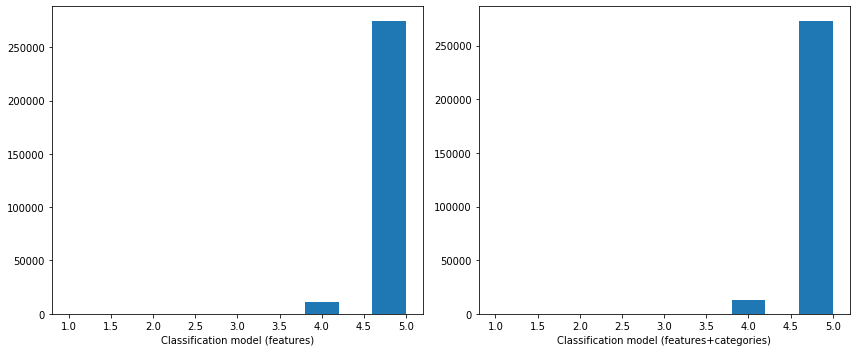

In [0]:
_ , axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
axs[0].hist(prediction_m1f1, bins=10)
axs[0].set_xlabel("Classification model (features)")
axs[1].hist(prediction_m1f2, bins=10)
axs[1].set_xlabel("Classification model (features+categories)")

Text(0.5, 0, 'Continuous model (features+categories)')

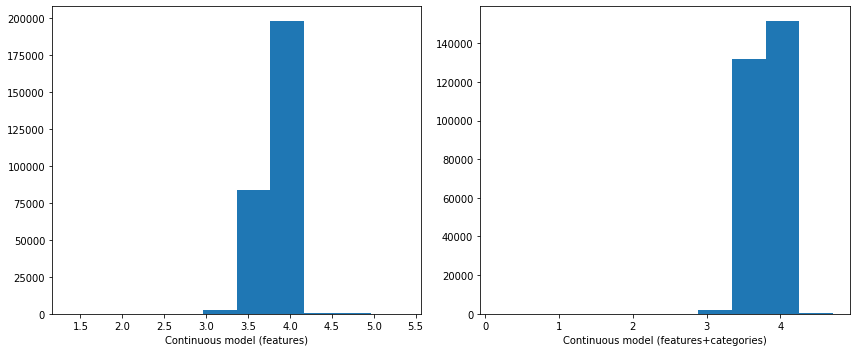

In [0]:
_ , axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
axs[0].hist(prediction_m2f1, bins=10)
axs[0].set_xlabel("Continuous model (features)")
axs[1].hist(prediction_m2f2, bins=10)
axs[1].set_xlabel("Continuous model (features+categories)")

In [0]:
#add prediction column to test set
test['prediction_m1f1'] = prediction_m1f1.flatten()
test['prediction_m1f2'] = prediction_m1f2.flatten()
test['prediction_m2f1'] = prediction_m2f1.flatten()
test['prediction_m2f2'] = prediction_m2f2.flatten()

In [0]:
#save predictions to file
test.to_csv(drive_root+"./Deep Learning Model/deeplearning_lastrating_predictions.csv", index=False)


In [0]:
test.head()

,review_id,user_id,business_id,rating,prediction_m1f1,prediction_m1f2,prediction_m2f1,prediction_m2f2
0,wEJK2PeiS6Au0TOyxTyqUA,---1lKK3aKOuomHnwAkAow,Hqs4YNST_ZHbshwyi4bnsQ,5.00,5,5,3.67,3.67
1,8QLqN2qZPeN6qh4i9tj-rw,--0kuuLmuYBe3Rmu0Iycww,PYe_FDw6QTbTf66WcGE_tw,2.00,5,5,3.85,3.82
2,dgtVm1qaV3KSzC1Cv7M7kg,--2HUmLkcNHZp0xw6AMBPg,KW9RNyBPmc77f9FsO92qYw,5.00,5,5,3.88,3.83
3,419OFmkJ4DSc2zkjuxX5hw,--2vR0DIsmQ6WfcSzKWigw,BLIJ-p5wYuAhw6Pp6mh6mw,3.00,5,5,3.84,3.81
4,6KblMvyPMH__K_eMKhHWOg,--3WaS23LcIXtxyFULJHTA,UKrfUw8quQiQM2N9i1nH0g,4.00,5,5,3.83,3.80
